# Supply Risks and Restocking Probabilities

#### Prepared for the CBC QuantEcon workshop (September 2022)

#### John Stachurski

In this lecture we will study the time path of inventories for firms that
follow s-S inventory dynamics.

Such firms

1. wait until inventory falls below some level $ s $ and then  
1. order sufficient quantities to bring their inventory back up to capacity $ S $.  

These kinds of policies are common in practice and also optimal in certain circumstances.

Our main task will be to calculate restocking probabilities over time via Monte Carlo.

In this lecture, we use the following imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from numba import njit, prange

## Dynamics

Consider a firm with inventory $ X_t $ at time $t$.

The time frequency is daily, so $X_{t+1} - X_t$ gives change in inventory over day $t$.

The firm 

* faces stochastic demand $ \{ D_t \} $, which we assume is IID, and
* waits until $ X_t \leq s $ and then restocks up to $ S $ units.


With notation $ a^+ := \max\{a, 0\} $, inventory dynamics can be written
as

$$
X_{t+1} =
    \begin{cases}
      ( S - D_{t+1})^+ & \quad \text{if } X_t \leq s \\
      ( X_t - D_{t+1} )^+ &  \quad \text{if } X_t > s
    \end{cases}
$$

In what follows, we will assume that each $ D_t $ is lognormal, so that

$$
D_t = \exp(\mu + \sigma Z_t)
$$

where $ \mu $ and $ \sigma $ are parameters and $ \{Z_t\} $ is IID
and standard normal.

We will use the following defaults for our parameters:

In [2]:
default_s, default_S = 10, 200
default_mu, default_sigma = 1.0, 0.8

Here is a simulation of one inventory path:

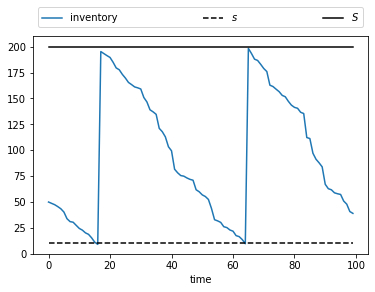

In [3]:
def update(x, s=default_s, S=default_S, mu=default_mu, sigma=default_sigma):
    Z = np.random.randn()
    D = np.exp(mu + sigma * Z)
    if x <= s:
        return max(S - D, 0)
    else:
        return max(x - D, 0)

def sim_inventory_path(x_init=50, sim_length=100):
    X = np.empty(sim_length)
    X[0] = x_init

    for t in range(sim_length-1):
        X[t+1] = update(X[t])
    return X

sim_length=100
X = sim_inventory_path(sim_length=sim_length)
s, S = default_s, default_S

fig, ax = plt.subplots()
bbox = (0., 1.02, 1., .102)
legend_args = {'ncol': 3,
               'bbox_to_anchor': bbox,
               'loc': 3,
               'mode': 'expand'}

ax.plot(X, label="inventory")
ax.plot(np.full(sim_length, s), 'k--', label="$s$")
ax.plot(np.full(sim_length, S), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.set_xlabel("time")
ax.legend(**legend_args)

plt.show()

## Restocking Probabilities

Suppose that there are risks in the supply chain that the firm needs to manage.

In particular, the firm's supplier can guarantee only one resupply (order of size $S$) in the next two months.

Let $t=0$ and current inventory $X_0 = 70$.

The firm's manager asks us to calculate the probability that firms that the firm needs to restock
more than once (i.e., twice or more) in the next two months (i.e., 60 days).

Our plan is to calculate this probability via Monte Carlo.

The basic procedure is:

1. Simulate many inventory paths of length 60 starting from $X_0 = 70$.
2. Compute the fraction of paths that fall below $s$ (and hence restock) more than once.

By the law of large numbers, this fraction converges to the corresponding probability.

We will simulate $10^7$ inventory paths.

In [4]:
sim_size = 10_000_000
x_init = 70.0
sim_length = 60

## JIT-Compiled on the CPU with Numba

In our first effort, we use loops and just-in-time compilation with Numba.

In [5]:
@njit
def compute_freq_jit(s=default_s,
                     S=default_S,
                     mu=default_mu,
                     sigma=default_sigma,
                     sim_length=sim_length, 
                     x_init=x_init, 
                     sim_size=sim_size):
    
    number_of_paths_with_multiple_restock = 0 
    
    for m in range(sim_size):
        x = x_init
        restock_counter = 0  # Records number of restocks for inventory path m

        for t in range(sim_length):
            Z = np.random.randn()
            D = np.exp(mu + sigma * Z)
            if x <= s:
                x = max(S - D, 0)
                restock_counter += 1
            else:
                x = max(x - D, 0)

        if restock_counter > 1:
            number_of_paths_with_multiple_restock += 1

    return number_of_paths_with_multiple_restock / sim_size

In [6]:
%%time
compute_freq_jit()

CPU times: user 18.5 s, sys: 19.1 ms, total: 18.5 s
Wall time: 18.4 s


0.1133697

In [7]:
%%time
compute_freq_jit()

CPU times: user 18.3 s, sys: 48.5 ms, total: 18.4 s
Wall time: 18.2 s


0.1132936

## Parallelized on the CPU with Numba

For our next effort, we are going to use essentially the same logic and, once again, the JIT compiler supplied by Numba.  At the same time, we are going to parallelize over the CPU to distribute the computational burden.

For this we set `parallel=True` and change the outer `range` function to `prange`, which has been imported from Numba.

In [8]:
@njit(parallel=True)
def compute_freq_prange(s=default_s,
                     S=default_S,
                     mu=default_mu,
                     sigma=default_sigma,
                     sim_length=sim_length, 
                     x_init=x_init, 
                     sim_size=sim_size):
    
    number_of_paths_with_multiple_restock = 0 
    
    for m in prange(sim_size):
        x = x_init
        restock_counter = 0  # Records number of restocks for inventory path m

        for t in range(sim_length):
            Z = np.random.randn()
            D = np.exp(mu + sigma * Z)
            if x <= s:
                x = max(S - D, 0)
                restock_counter += 1
            else:
                x = max(x - D, 0)

        if restock_counter > 1:
            number_of_paths_with_multiple_restock += 1

    return number_of_paths_with_multiple_restock / sim_size

In [9]:
%%time
compute_freq_prange()

CPU times: user 26 s, sys: 11.3 ms, total: 26 s
Wall time: 3.74 s


0.1135043

In [10]:
%%time
compute_freq_prange()

CPU times: user 25.5 s, sys: 15.7 ms, total: 25.5 s
Wall time: 3.29 s


0.1133054

Execution time on a machine with 8 cores is around 4 times faster.   Machines with more cores will get greater speed gains.

## Vectorized NumPy version

As an alternative, let's try a vectorized version that's accelerated just by NumPy operators.

The idea is to 

1. update all the inventory paths at once and
2. note which of the paths involve a restock

These two operations are vectorized.  The outer loop is not vectorized or accelerated, since it makes little difference to efficiency.

In [11]:
def compute_freq_vectorized(s=default_s,
                            S=default_S,
                            mu=default_mu,
                            sigma=default_sigma,
                            sim_length=sim_length, 
                            x_init=x_init, 
                            num_firms=sim_size):
  
    x = np.full(sim_size, x_init)
    restock_counters = np.zeros_like(x)
    for i in range(sim_length):
        restock_counters += np.where(x < s, 1, 0)
        D = np.exp(mu + sigma * np.random.randn(num_firms))
        y = np.where(x < s, S, x)
        x = np.maximum(y - D, 0)
    return np.mean(restock_counters > 1)

In [12]:
%%time
compute_freq_vectorized()

CPU times: user 12.8 s, sys: 2.65 s, total: 15.5 s
Wall time: 15.5 s


0.1134294

In [13]:
%%time
compute_freq_vectorized()

CPU times: user 13 s, sys: 2.92 s, total: 15.9 s
Wall time: 15.9 s


0.1132471

On a typical machine, the speed is similar to the non-parallelized Numba-accelerated version.

## Vectorized with JAX

To further accelerate the operation, let's move to the GPU.  Here's the current device:

In [14]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



JAX code is typically vectorized, so our implementation looks a lot like the NumPy vectorized code we showed above.  In fact the only changes are

1. `np` is replaced by `jnp` (JAX NumPy) in each instance and
2. we use a JAX-specific random number generator.

In [15]:
def compute_freq_jax(s=default_s,
                     S=default_S,
                     mu=default_mu,
                     sigma=default_sigma,
                     sim_length=sim_length, 
                     x_init=x_init, 
                     sim_size=sim_size):
  
    
    x = jnp.full(sim_size, x_init)
    
    restock_counters = jnp.zeros_like(x)
    for t in range(sim_length):
        restock_counters += jnp.where(x < s, 1, 0)
        key = jax.random.PRNGKey(t)
        Z = jax.random.normal(key, (sim_size,))
        D = jnp.exp(mu + sigma * Z)
        y = jnp.where(x < s, S, x)
        x = jnp.maximum(y - D, 0)
    return jnp.mean(restock_counters > 1)

In [16]:
%%time 
compute_freq_jax()

2022-09-13 15:46:46.173831: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


CPU times: user 13 s, sys: 5.97 s, total: 19 s
Wall time: 13.8 s


DeviceArray(0.1133754, dtype=float32)

In [17]:
%%time 
compute_freq_jax()

CPU times: user 12.4 s, sys: 6.05 s, total: 18.4 s
Wall time: 5.82 s


DeviceArray(0.1133754, dtype=float32)

In [ ]:
%%time 
compute_freq_jax()

With a decent GPU, we now have a huge speed gain --- around two orders of magnitude.

But we can do even better...

## Vectorized and JIT Compiled with JAX

Our next step and final step is to apply the JAX JIT compiler to the JAX implementation given above.

In [ ]:
compute_freq_jax_jit = jax.jit(compute_freq_jax)

On the first iteration we expect substatial compile time:

In [ ]:
%%time 
compute_freq_jax_jit()

Now it's compiled, let's check the speed:

In [ ]:
%%time 
compute_freq_jax_jit()

We now have a massive speed gain --- around 4 orders of magnitude.